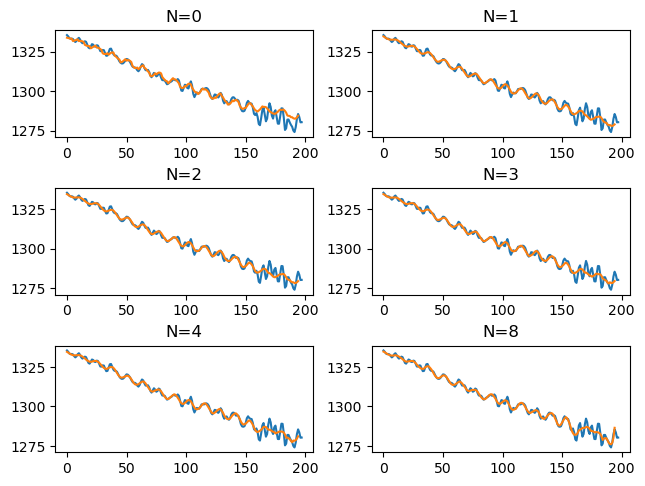

In [36]:
"""
Notebook for visualizing different order polynomial differences
"""


#Define imports
from scipy.io import loadmat
from scipy import signal
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from em_apex_processing import *
from spectral_processing import *
import os
import warnings


#########################
Cmax=100
uVpc = 1e6 * (10e-3 / (2**24))

nstep_off=5
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60 #
#Andy sets navg (spectrum time windowing) to 120
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-efr.mat"
gpsfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-gps.mat"
ctdfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-ctd.mat"
EFR = loadmat(fname)


efr_times = EFR['UXT'] - EFR['AGE']
efr_times = efr_times[0, :]
seqno = EFR['SEQNO'][0, :]

#Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
p = np.polyfit(seqno,efr_times,1)
pfit = np.poly1d(p)
mlt_efr = pfit(seqno);

GPS = loadmat(gpsfname)
CTD = loadmat(ctdfname)


ctd_time = CTD["UXT"][0, :]
P = CTD["P"][0, :]
Pef = np.interp(mlt_efr, ctd_time, P)
#Pef = Pef-5

tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
#Convert time to fractional year for use in the igrf function
frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
avg_lat = np.nanmean(GPS["LAT"][0, :])
avg_lon = np.nanmean(GPS["LON"][0, :])
avg_frac_yrs = np.nanmean(frac_yrs)

#Get magnetic field values
[Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)


fz=-np.nanmean(Bz);
fh=np.nanmean(np.sqrt(Bx**2+By**2));
sfv1 = 1e3/(fz*esep1*(1.0+c1));
sfv2 = 1e3/(fz*esep2*(1.0+c1));

#Convert from counts to microvolts
E1 = (EFR["E1"][0, :]-2**23) * uVpc;
E2 = (EFR["E2"][0, :]-2**23) * uVpc;

#pull out compass values
HZ = EFR["HZ"][0, :];
HY = EFR["HY"][0, :];
HX = EFR["HX"][0, :];


Nfit_arr = [0, 1, 2, 3, 4, 8]
plt.figure()
count =1
for Nfit in Nfit_arr:
    
    #Do the 50s fits 
    [e1offs,e2offs,e1fits,e2fits,anghxhy] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

    #Get overall fi and calculate the residuals
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        e1off=np.nanmean(e1offs,1);
        e2off=np.nanmean(e2offs,1);
        e1fit=np.nanmean(e1fits,1);
        e2fit=np.nanmean(e2fits,1);
    
    plt.subplot(3, 2, count)
    plt.plot(E2[600:])
    plt.plot(e2fit[600:])
    plt.title("N="+str(Nfit))
    
    count+=1
plt.tight_layout(pad=0.5)
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/voltage_fits_varying_N.png")


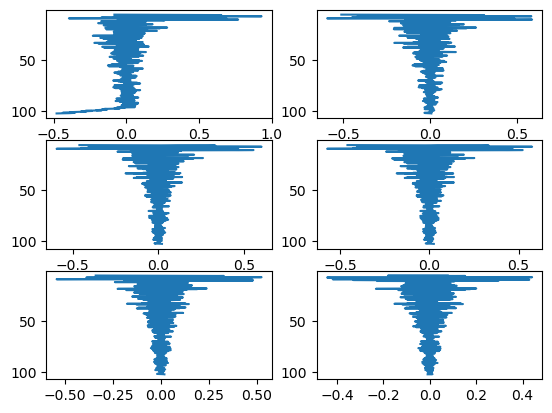

In [13]:
count=1
for Nfit in Nfit_arr:
    
    #Do the 50s fits 
    [e1offs,e2offs,e1fits,e2fits,anghxhy] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

    #Get overall fi and calculate the residuals
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        e1off=np.nanmean(e1offs,1);
        e2off=np.nanmean(e2offs,1);
        e1fit=np.nanmean(e1fits,1);
        e2fit=np.nanmean(e2fits,1);
    
    plt.subplot(3, 2, count)
    plt.plot((E2-e2fit)*sfv2, Pef)
    plt.gca().invert_yaxis()

    
    count+=1